In [6]:
import micropip
await micropip.install(["kaibu-utils", "imjoy-rpc", "pyodide_http"])

import pyodide_http
pyodide_http.patch_all()  # Patch all libraries


(512, 512, 3)


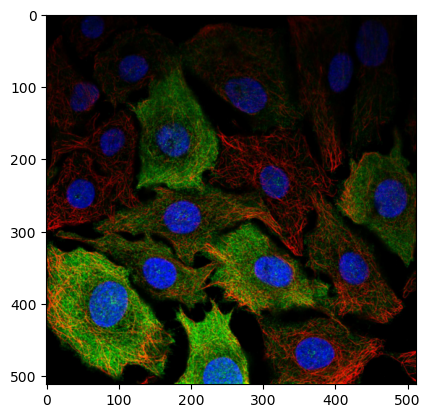

In [7]:
from js import fetch
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from kaibu_utils import fetch_image, features_to_mask, mask_to_features

from imjoy_rpc.hypha import connect_to_server
server = await connect_to_server(
    {"name": "test client", "server_url": "https://hypha.bioimage.io/", "method_timeout": 3000}
)
triton = await server.get_service("triton-client")


def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def cellpose_segment(image, diameter=100):
    results = await triton.execute(inputs=[image.transpose(2, 0, 1), {'diameter': diameter}],
                model_name='cellpose-python',
                decode_bytes=True)
    mask = results['mask'][0].copy()
    return mask

image = await fetch_image("https://images.proteinatlas.org/61448/1319_C10_2_blue_red_green.jpg")
image = image.astype('float32')
image = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True).astype('float32')
print(image.shape)
plt.imshow(image.astype('uint8'))
plt.show()

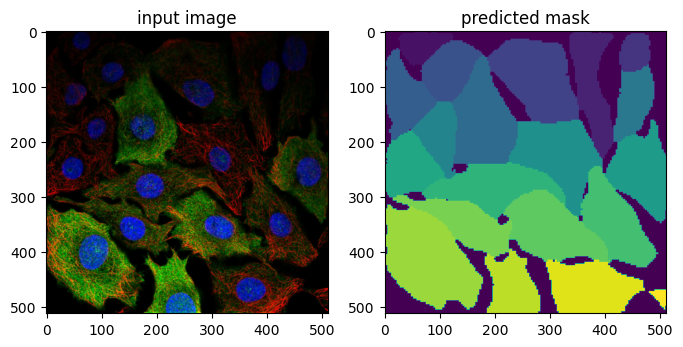

In [8]:
mask = await cellpose_segment(image, diameter=100)
display_image(image.astype('uint8'), mask)

In [9]:
from imjoy import api

class ImJoyPlugin():
    async def setup(self):
        viewer = await api.createWindow(src="https://kaibu.org/#/app")
        
        # Add an image layer and annotation layer
        await viewer.view_image(image.astype('uint8'))
        annotation_layer = await viewer.add_shapes([], {"name": "annotation"})
        
        async def do_segmentation():
            mask = await cellpose_segment(image)
            # await viewer.view_image(mask, name="mask")
            polygons = mask_to_features(mask)
            await viewer.add_shapes(
                polygons,
                shape_type="polygon",
                edge_color="red",
                name="prediction",
            )

        await viewer.add_widget(
        {
            "_rintf": True,
            "name": "Control",
            "type": "control",
            "elements": [
                {
                    "type": "button",
                    "label": "Do Segmentation",
                    "callback": do_segmentation,
                }
            ],
        })

api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

<PyodideFuture finished result=[]>